In [1]:
### Import required packages
import csv
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Helps to obtain the FFT
import scipy.fftpack    
# Various operations on signals (waveforms)
import scipy.signal as signal
import neurokit2 as nk
from scipy.io import loadmat


In [2]:
                                                    ###Obtain ecg sample from csv file using pandas###
# dataset = loadmat(r"D:\HearDiseaseDeteactionandStokePrediction\A0004.mat")
# dataset = pd.DataFrame({k: pd.Series(v[0]) for k, v in dataset.items()})

dataset = pd.read_csv(r"C:\Users\AAA\Desktop\Projects and Researchs\JiT Research\2021\Heart disease and brain stroke\Heart disease\ecg_3000hz.csv")
y = dataset[dataset.columns[0]]

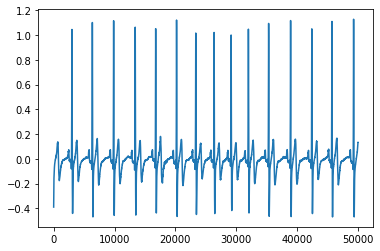

In [3]:
plt.plot(y)

In [4]:
# Number of samplepoints
N = len(y)
# sample spacing
fs = 3000
t = 1.0 / fs
#Compute x-axis
x = np.linspace(0.0, N*t, N)

In [6]:
rpeaks = nk.ecg_findpeaks(y, sampling_rate=fs)

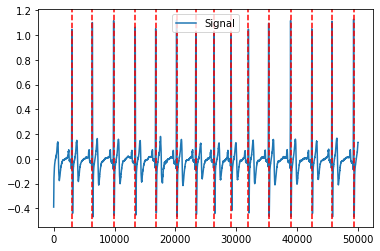

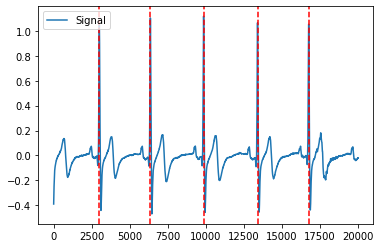

In [9]:
plot = nk.events_plot(rpeaks['ECG_R_Peaks'], y)

# Zooming into the first 5 R-peaks
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:5], y[:20000])

In [10]:
# Delineate the ECG signal
_, waves_peak = nk.ecg_delineate(y, rpeaks, sampling_rate=fs, method="peak")

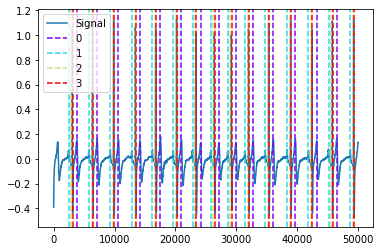

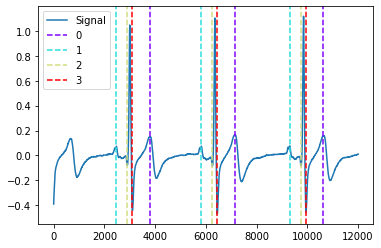

In [15]:
plot = nk.events_plot([waves_peak['ECG_T_Peaks'],
                       waves_peak['ECG_P_Peaks'],
                       waves_peak['ECG_Q_Peaks'],
                       waves_peak['ECG_S_Peaks']], y)

# Zooming into the first 3 R-peaks, with focus on T_peaks, P-peaks, Q-peaks and S-peaks
plot = nk.events_plot([waves_peak['ECG_T_Peaks'][:3],
                       waves_peak['ECG_P_Peaks'][:3],
                       waves_peak['ECG_Q_Peaks'][:3],
                       waves_peak['ECG_S_Peaks'][:3]], y[:12000])


In [17]:
# Delineate the ECG signal and visualizing all peaks of ECG complexes
_, waves_peak = nk.ecg_delineate(y, rpeaks, sampling_rate=fs, method="peak", show=False, show_type='peaks')

In [18]:
T = np.array(waves_peak['ECG_T_Peaks'])
P = np.array(waves_peak['ECG_P_Peaks'])
Q = np.array(waves_peak['ECG_Q_Peaks'])
S = np.array(waves_peak['ECG_S_Peaks'])
T = T[0:len(T)-1]
P = P[0:len(P)-1]
Q = Q[0:len(Q)-1]
S = S[0:len(S)-1]


In [19]:
wave_s = y[S]
wave_t = y[T]
wave_q = y[Q]
wave_p = y[P]

In [20]:
#ST depression 
min_index_of_S = np.argmin(S)
min_S = abs(np.min(wave_s)) #ST depression in mv absoulute value 
req_T = np.min(wave_t)
req_Q = np.min(wave_q)
req_P = np.min(wave_p)
min_Smm = min_S*10 #ST depression in mm


In [21]:
wave_t = np.array(wave_t)
wave_s = np.array(wave_s)
wave_q = np.array(wave_q)
wave_p = np.array(wave_p)

In [22]:
#QRS duration 
qrs_duration = S - Q
qrs_duration = qrs_duration/fs
qrs_duration = np.average(qrs_duration)*1000 #in milli seconds

In [23]:
#ST slope
st_slope =[]
for i in range (0,len(T)):
    st_slope.append((wave_t[i] - wave_s[i])/(T[i]-S[i]))
    
#Average ST slope
st_slope_av = np.average(st_slope)

In [24]:
#QT interval 
qt_interval = T - Q
qt_interval = qt_interval/fs
qt_interval = np.average(qt_interval) *1000 #in milliseconds


In [26]:
#Amplitude of R wave
Rp= np.array(rpeaks['ECG_R_Peaks'])
R = y[Rp]
R_av = np.average(np.array(R)) #in mV
R_avmm = R_av*10 #in mm


In [28]:
#Amplitude of Q wave
Qp= np.array(waves_peak['ECG_Q_Peaks'])
Q = abs(y[Qp])
Q_av = np.average(np.array(Q)) #in mV
Q_avmm = R_av*10 #in mm

In [29]:
#Amplitude of P wave
P = np.array(waves_peak['ECG_P_Peaks'])
P_amp = y[P]
P_avam = np.average(np.array(P_amp)) #in mV
P_avmm = P_avam*10 #in mm

In [30]:
#Amplitude of T wave
T = np.array(waves_peak['ECG_T_Peaks'])
T = T[0:len(T)-1]
T_amp = y[T]
T_avam = np.average(np.array(T_amp)) #in mV
T_avmm = T_avam*10 #in mm

In [73]:
#PR interval 
Rp= np.array(rpeaks['ECG_R_Peaks'])
P = np.array(waves_peak['ECG_P_Peaks'])
PR_interval = Rp-P
PR_interval = PR_interval/fs
PR_interval = np.average(PR_interval) * 1000 #in miliseconds

In [74]:
#Average Hear rate calculation 
RR_list = []
cnt = 0
while (cnt < (len(rpeaks['ECG_R_Peaks'])-1)):
    
    RR_interval = (rpeaks['ECG_R_Peaks'][cnt+1] - rpeaks['ECG_R_Peaks'][cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1

bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
print("\n\n\nAverage Heart Beat is: %.01f\n" %(bpm)) #Round off to 1 decimal and print
print("No of peaks in sample are {0}".format(len(rpeaks['ECG_R_Peaks'])))




Average Heart Beat is: 54.5

No of peaks in sample are 15


In [75]:
# Corrected QT interval (QTc) using Bazett formula

qtc = qt_interval/np.sqrt(np.mean(RR_list))